# Automatic Fraud Detection - EDA and modelization




Contents
--------
1. [Data loading and preprocessing](#loading)
2. [Preliminary data analysis](#eda)
3. [Data preprocessing and utilities](#preproc_utils)
4. [Logistic regression](#logreg)
5. [Random forest](#random_forest)
6. [Histogram-based Gradient Boosting model](#hist_gb)

In [2]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (OneHotEncoder,
                                   OrdinalEncoder,
                                   StandardScaler,
                                   FunctionTransformer)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier,
                              HistGradientBoostingClassifier)

pd.set_option('display.max_columns', None)

## <a id="loading"></a> Data loading and preprocessing


In [3]:
raw_df = pd.read_csv('./data/fraudTest.csv')
raw_df = raw_df.drop('Unnamed: 0', axis=1)

raw_df

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555714,2020-12-31 23:59:07,30560609640617,fraud_Reilly and Sons,health_fitness,43.77,Michael,Olson,M,558 Michael Estates,Luray,MO,63453,40.4931,-91.8912,519,Town planner,1966-02-13,9b1f753c79894c9f4b71f04581835ada,1388534347,39.946837,-91.333331,0
555715,2020-12-31 23:59:09,3556613125071656,fraud_Hoppe-Parisian,kids_pets,111.84,Jose,Vasquez,M,572 Davis Mountains,Lake Jackson,TX,77566,29.0393,-95.4401,28739,Futures trader,1999-12-27,2090647dac2c89a1d86c514c427f5b91,1388534349,29.661049,-96.186633,0
555716,2020-12-31 23:59:15,6011724471098086,fraud_Rau-Robel,kids_pets,86.88,Ann,Lawson,F,144 Evans Islands Apt. 683,Burbank,WA,99323,46.1966,-118.9017,3684,Musician,1981-11-29,6c5b7c8add471975aa0fec023b2e8408,1388534355,46.658340,-119.715054,0
555717,2020-12-31 23:59:24,4079773899158,fraud_Breitenberg LLC,travel,7.99,Eric,Preston,M,7020 Doyle Stream Apt. 951,Mesa,ID,83643,44.6255,-116.4493,129,Cartographer,1965-12-15,14392d723bb7737606b2700ac791b7aa,1388534364,44.470525,-117.080888,0


In [4]:
raw_df.describe(include='all')

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
count,555719,5.557190e+05,555719,555719,555719.000000,555719,555719,555719,555719,555719,555719,555719.000000,555719.000000,555719.000000,5.557190e+05,555719,555719,555719,5.557190e+05,555719.000000,555719.000000,555719.000000
unique,544760,NaN,693,14,NaN,341,471,2,924,849,50,NaN,NaN,NaN,NaN,478,910,555719,NaN,NaN,NaN,NaN
top,2020-10-05 19:37:49,NaN,fraud_Kilback LLC,gas_transport,NaN,Christopher,Smith,F,444 Robert Mews,Birmingham,TX,NaN,NaN,NaN,NaN,Film/video editor,1977-03-23,1765bb45b3aa3224b4cdcb6e7a96cee3,NaN,NaN,NaN,NaN
freq,4,NaN,1859,56370,NaN,11443,12146,304886,1474,2423,40393,NaN,NaN,NaN,NaN,4119,2408,1,NaN,NaN,NaN,NaN
mean,NaN,4.178387e+17,NaN,NaN,69.392810,NaN,NaN,NaN,NaN,NaN,NaN,48842.628015,38.543253,-90.231325,8.822189e+04,NaN,NaN,NaN,1.380679e+09,38.542798,-90.231380,0.003860
std,NaN,1.309837e+18,NaN,NaN,156.745941,NaN,NaN,NaN,NaN,NaN,NaN,26855.283328,5.061336,13.721780,3.003909e+05,NaN,NaN,NaN,5.201104e+06,5.095829,13.733071,0.062008
min,NaN,6.041621e+10,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,1257.000000,20.027100,-165.672300,2.300000e+01,NaN,NaN,NaN,1.371817e+09,19.027422,-166.671575,0.000000
25%,NaN,1.800429e+14,NaN,NaN,9.630000,NaN,NaN,NaN,NaN,NaN,NaN,26292.000000,34.668900,-96.798000,7.410000e+02,NaN,NaN,NaN,1.376029e+09,34.755302,-96.905129,0.000000
50%,NaN,3.521417e+15,NaN,NaN,47.290000,NaN,NaN,NaN,NaN,NaN,NaN,48174.000000,39.371600,-87.476900,2.408000e+03,NaN,NaN,NaN,1.380762e+09,39.376593,-87.445204,0.000000
75%,NaN,4.635331e+15,NaN,NaN,83.010000,NaN,NaN,NaN,NaN,NaN,NaN,72011.000000,41.894800,-80.175200,1.968500e+04,NaN,NaN,NaN,1.385867e+09,41.954163,-80.264637,0.000000


The dataset has 555719 rows, each corresponds to a transaction

We are in the presence of the following variables:
- Datetime-like variables
  - `trans_date_trans_time`, the transaction datetime
  - `dob`, the date of birth of the customer
  - `unix_time`, the unix time, probably of the transaction. For
  instance the value of the first row corresponds to 2013-06-21T12:14:25 UTC
  Which is the same as the corresponding `trans_date_trans_time`, save for the year
  (2013 vs 2020)
- Categorical variables
  - `cc_num`, the credit card number. It is a categorical variable,
  despite the fact that it is encoded as an integer.
  - `merchant`, the merchant name
  - `category`, the purchased goods category
  - `first`, `last`, `gender`, `job`, information about the customer
  - `street`, `city`, `state`, `zip`, location information about the customer
  - `trans_num`, the transaction number
- Boolean variables:
  - `is_fraud`, our target
- Quantitative variables:
  - `amt`, the transaction amount.
  - `city_pop`, the population of the city
  - `lat` and `long`, the geographic coordinates of the customer
  - `merch_lat` and `merch_long`, the geographic coordinates of the merchant

In [5]:
## cast the quantitative variable to float, for better handling of missing values
raw_df = raw_df.astype({'trans_date_trans_time': 'datetime64[s]'})

## discard the 'fraud_' string before each merchant value
raw_df['merchant'] = raw_df['merchant'].apply(lambda x: x.strip('fraud_'))

The dataset contains private information about about customers and merchants
(address, name, etc). We therefore build two reference tables, `merchants` and
`customers`, that are dedicated to hold this sensitive information.

In [ ]:
## `customer` reference table
customer_cols = ['cc_num', 'first', 'last', 'gender', 'street', 'city',
                 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob']
customers_df = raw_df[customer_cols].value_counts().index.to_frame()
customers_df.index = pd.Index(np.arange(1, len(customers_df)+1),
                              name='customer_id')

## compute customer fraudster status
cust_fraud = pd.merge(raw_df[customer_cols + ['is_fraud']],
                      customers_df.assign(customer_id=customers_df.index),
                      how='left', on=customer_cols)
cust_fraud = cust_fraud[['is_fraud', 'customer_id']]

## add fraudster status to customers table
cust_fraudster = cust_fraud.groupby('customer_id').any() \
                           .rename({'is_fraud': 'cust_fraudster'}, axis=1)
customers_df = customers_df.join(cust_fraudster, validate='one_to_one')

In [ ]:
customers_df

,cc_num,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,cust_fraudster
customer_id,,,,,,,,,,,,,,
1,6538441737335434,Gina,Grimes,F,444 Robert Mews,Clarks Mills,PA,16114,41.3851,-80.1752,606,Energy manager,1997-09-22,True
2,4586810168620942,Michelle,Gregory,F,6983 Carrillo Isle,Edisto Island,SC,29438,32.5486,-80.3070,2408,"Sales professional, IT",1997-07-05,False
3,4745996322265,Carrie,Washington,F,6114 Adams Harbor Suite 096,Kingsford Heights,IN,46346,41.4802,-86.6919,1423,"Psychologist, forensic",1998-10-07,False
4,4587657402165341815,Amber,Lewis,F,6296 John Keys Suite 858,Pembroke Township,IL,60958,41.0646,-87.5917,2135,"Psychotherapist, child",2004-05-08,False
5,2242542703101233,Samuel,Jenkins,M,43235 Mckenzie Views Apt. 837,Westport,KY,40077,38.4921,-85.4524,564,Pensions consultant,1996-04-10,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
920,4883407061576,Rachel,Williams,F,6386 Bailey Hill Apt. 421,Seattle,WA,98118,47.5412,-122.2750,837792,Systems developer,1936-12-23,True
921,4087542780207162,Nicole,Dominguez,F,537 Brian Island,Guthrie,OK,73044,35.8330,-97.4360,20226,Retail manager,1969-11-08,True
922,3540416671210051,Stephanie,Freeman,F,44613 James Turnpike,Rice,MN,56367,45.7364,-94.1658,6263,"Engineer, water",1944-05-30,True


In [8]:
## `merchants` reference table
merchant_cols = ['merchant']
merchants_df = raw_df[merchant_cols].value_counts().index.to_frame()
merchants_df.index = pd.Index(np.arange(1, len(merchants_df)+1),
                              name='merchant_id')

## compute merchant victim status
merch_victim = pd.merge(raw_df[merchant_cols + ['is_fraud']],
                        merchants_df.assign(merchant_id=merchants_df.index),
                        how='left', on=merchant_cols)
merch_victim = merch_victim[['is_fraud', 'merchant_id']] \

## add fraudster status to merchants table
merch_fraud_victim = merch_victim.groupby('merchant_id').any() \
                                 .rename({'is_fraud': 'merch_fraud_victim'}, axis=1)
merchants_df = merchants_df.join(merch_fraud_victim, validate='one_to_one')

In [9]:
merchants_df

,merchant,merch_fraud_victim
merchant_id,,
1,Kilback LLC,True
2,Cormier LLC,True
3,Schumm PLC,True
4,Kuhn LLC,True
5,Dickinson Lt,True
...,...,...
689,Treutel-King,False
690,Satterfield-Lowe,True
691,Kessler Group,False


A lot of the variables of the dataset are either irrelevant (eg the transaction number) or impossible to use (eg the address). Moreover, the personal information may not be legal to use in a realistic context. We therefore produce a new set of features for fraud detection:
- `merchant_id`, `customer_id`, these two quantities link to reference table entries to determine `cust_fraudster` and `merch_fraud_victim`
- `month`, `weekday`, `day_time`, date and time of the transaction
- `amt`, the transaction amount
- `category`, the category of the goods boughts
- `cust_fraudster`, indicates whether the customer has already commited fraud
- `merch_fraud_victim`, indicated whether the merchant has already been victim of fraud

In [7]:
dt = raw_df['trans_date_trans_time'].dt
cust_fraud_map = dict(customers_df['cust_fraudster'])
merch_fraud_map = dict(merchants_df['merch_fraud_victim'])

df = pd.DataFrame({
    'merchant_id': merch_victim['merchant_id'],
    'customer_id': cust_fraud['customer_id'],
    'month': dt.month,
    'weekday': dt.weekday,
    'day_time': (raw_df['trans_date_trans_time'] - dt.floor('D')).dt.seconds,
    'amt': raw_df['amt'],
    'category': raw_df['category'],
    'cust_fraudster': cust_fraud['customer_id'].map(cust_fraud_map),
    'merch_fraud_victim': merch_victim['merchant_id'].map(merch_fraud_map),
    'is_fraud': raw_df['is_fraud']
    })

In addition, since the day time and week day are cyclic (e.g., 1h is as close to 23h as 15h is close to 13h), we create derived features by taking the sine and cosine of these variables. The case of cyclic quantitative variables is problematic for some models, which do not "see" the periodic nature of the data. The typical example is the day time, where 1:00 is as close to 23:00 as 15:00 is close to 13:00. Such features require a specific handling. One approach is to decompose the feature $X$ with period $T(X)$ on a set of periodic functions, e.g., sine and cosine:
$$\cos \left( 2 k \pi X / T(X) \right), \quad \cos \left( 2 k \pi X / T(X) \right).$$
The harmonics $k$ must be chosen manually to maximize the predictive power of the model.

We apply this method to the `day_time` feature. To keep thins simple, we limit ourselves to $k=1$ to capture simple periodic structures. This yields the two features:
$$\cos(2 \pi \times \mathrm{day\_time} / \mathrm{24h}), \quad \cos(2 \pi \times \mathrm{day\_time} / \mathrm{24h}).$$

In [8]:
## Add cosine and sine of periodic features
df = df.assign(cos_day_time=np.cos(2*np.pi*df['day_time']/86400),
               sin_day_time=np.sin(2*np.pi*df['day_time']/86400),)

In [9]:
## Export training data to csv
# df.to_csv('./data/fraud_train_data.csv', index=False)

## <a id="eda"></a> Preliminary data analysis

We begin with an exploratory data analysis to get insights on the factors influencing the fraud risk.

In [10]:
cat_vars = ['month', 'weekday', 'category']
bool_vars = ['cust_fraudster', 'merch_fraud_victim']
quant_vars = ['day_time', 'amt', 'cos_day_time', 'sin_day_time']

In [11]:
print('Number of merchants victim of fraud :',
      merchants_df['merch_fraud_victim'].sum())

print('Number of fraudster customers :',
      customers_df['cust_fraudster'].sum())

Number of merchants victim of fraud : 557
Number of fraudster customers : 218


In [12]:
df.describe(include='all')

,merchant_id,customer_id,month,weekday,day_time,amt,category,cust_fraudster,merch_fraud_victim,is_fraud,cos_day_time,sin_day_time
count,555719.000000,555719.000000,555719.000000,555719.000000,555719.000000,555719.000000,555719,555719,555719,555719.000000,555719.000000,555719.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,14,2,2,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,gas_transport,False,True,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,56370,430775,459669,NaN,NaN,NaN
mean,287.888249,320.535976,9.508536,2.726779,47912.236972,69.392810,NaN,NaN,NaN,0.003860,0.002234,-0.138201
std,188.182499,237.150246,1.978205,2.178681,24540.647681,156.745941,NaN,NaN,NaN,0.062008,0.707892,0.692666
min,1.000000,1.000000,6.000000,0.000000,0.000000,1.000000,NaN,NaN,NaN,0.000000,-1.000000,-1.000000
25%,125.000000,116.000000,8.000000,1.000000,27565.000000,9.630000,NaN,NaN,NaN,0.000000,-0.705872,-0.797891
50%,266.000000,273.000000,10.000000,2.000000,50946.000000,47.290000,NaN,NaN,NaN,0.000000,0.002182,-0.275358
75%,440.000000,484.000000,12.000000,5.000000,68709.500000,83.010000,NaN,NaN,NaN,0.000000,0.711924,0.534967


In [13]:
loc = (df['merch_fraud_victim'] == True) & (df['cust_fraudster'] == True)
print(df.loc[loc].describe(include='all'))

          merchant_id    customer_id          month        weekday  \
count   103674.000000  103674.000000  103674.000000  103674.000000   
unique            NaN            NaN            NaN            NaN   
top               NaN            NaN            NaN            NaN   
freq              NaN            NaN            NaN            NaN   
mean       270.329099     307.636804       9.506665       2.733926   
std        186.939802     234.547304       1.976153       2.171892   
min          1.000000       1.000000       6.000000       0.000000   
25%        108.000000     115.000000       8.000000       1.000000   
50%        241.000000     257.000000      10.000000       3.000000   
75%        418.000000     474.000000      12.000000       5.000000   
max        692.000000     924.000000      12.000000       6.000000   

             day_time            amt       category cust_fraudster  \
count   103674.000000  103674.000000         103674         103674   
unique            N

- The transactions originate from 693 merchants and 917 customers.
- Of the 557/693 (80.4 %) merchants were victim of fraud.
- Of the 218/917 (23.6 %) customers are fraudsters.
- The amount spent is usually low, 70 on average, with 75% of the transactions corresponding to an amount less than 83. However, the standard deviation, 157, is rather large in comparison. This indicates that the transactions amounts have a long trail of high values (up to 22768).
- The fraud probability is rather low, about 0.4%, but it increases to 2% when we condition on fraudster customers and merchants victim of fraud.

### Effect of the sold goods category on the fraud probability

In [14]:
fraud_vs_categ = pd.concat(
    [df['category'].value_counts(),
     df.loc[:, ['category', 'is_fraud']].groupby('category').mean()],
    axis=1)

fraud_vs_categ

,count,is_fraud
category,,
gas_transport,56370,0.002732
grocery_pos,52553,0.009229
home,52345,0.001280
shopping_pos,49791,0.004278
kids_pets,48692,0.001335
shopping_net,41779,0.012111
entertainment,40104,0.001471
personal_care,39327,0.001780
food_dining,39268,0.001375


The fraud probability is actually quite low (about 0.2 %) for most categories. Only 3 categories are associated to a significantly higher fraud risk (about 1 %): `grocery_pos`, `Misc_net` and `shopping_net`.

### Distribution of transfered amounts

We mentioned a very broad distribution of transaction amounts. To get more detailed
insights, we compute the inverse cummultive distribution function, $P(X \geq x)$,
where $X$ represents the transaction amount.

In [15]:
amt_vals = np.logspace([0], [5], 101)
amt_icdf = np.sum(df['amt'].to_numpy() > amt_vals, axis=1) / len(df['amt'])

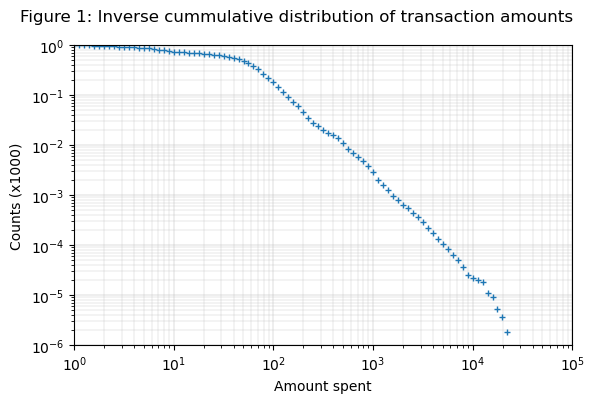

In [16]:
fig1, ax1 = plt.subplots(
    nrows=1, ncols=1, figsize=(6, 4), dpi=100,
    gridspec_kw={'left': 0.11, 'right': 0.94, 'top': 0.89, 'bottom': 0.14})
fig1.suptitle("Figure 1: Inverse cummulative distribution of transaction amounts",
              x=0.02, ha='left')

ax1.plot(amt_vals, amt_icdf, linestyle='', marker='+', markersize=5)

ax1.set_xscale('log')
ax1.set_xlim(1, 1e5)
ax1.set_xlabel('Amount spent')
ax1.set_yscale('log')
ax1.set_ylim(1e-6, 1)
ax1.set_ylabel('Counts (x1000)', labelpad=5)
ax1.grid(visible=True, linewidth=0.3)
ax1.grid(visible=True, which='minor', linewidth=0.2)


plt.show()

As anticipated, we observe that 90% of the transactions correspond to amounts less that 100. However, after the threshold at 100, We have a slow power-law decrease of the transaction amount. This leads to a significant fraction of very high transaction amounts. More than 1/1000 transactions corresponds to amounts > 1500.

### Correlation between non-categorical features

In [17]:
## Correlation matrix
df_ = df.loc[:, ['is_fraud'] + quant_vars + bool_vars]
corr = df_.corr().to_numpy()

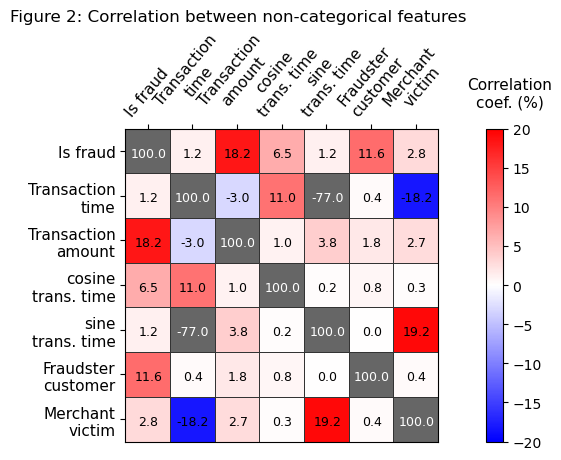

In [18]:
fig2, ax2 = plt.subplots(
    nrows=1, ncols=1, figsize=(5.6, 4.6), dpi=100,
    gridspec_kw={'left': 0.15, 'right': 0.86, 'top': 0.72, 'bottom': 0.04, 'wspace': 0.24})
cax2 = fig2.add_axes((0.87, 0.04, 0.03, 0.68))
fig2.suptitle("Figure 2: Correlation between non-categorical features",
              x=0.02, ha='left')


ax2.set_aspect('equal')
cmap2 = plt.get_cmap('bwr').copy()
cmap2.set_extremes(under='0.4', over='0.4')
heatmap = ax2.pcolormesh(corr[::-1]*100, cmap=cmap2, vmin=-20, vmax=20,
                             edgecolors='0.2', linewidth=0.5)

ax2.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ticklabels = ['Is fraud', 'Transaction\ntime', 'Transaction\namount',
              'cosine\ntrans. time', 'sine\ntrans. time',
              'Fraudster\ncustomer', 'Merchant\nvictim']
ax2.set_xticks(np.linspace(0.5, 6.5, 7), ticklabels, rotation=50,
               ha='center', fontsize=11)
ax2.set_yticks(np.linspace(6.5, 0.5, 7), ticklabels, rotation=0,
               ha='right', fontsize=11)

for (i, j), c in np.ndenumerate(corr[::-1]*100):
    ax2.text(j+0.52, i+0.45, f'{c:.1f}', color='w' if abs(c) > 50 else 'k',
             ha='center', va='center', fontsize=9)

pos = ax2.get_position().bounds
x, y = pos[0], pos[1] + pos[3]

fig2.colorbar(heatmap, cax=cax2, orientation="vertical", ticklocation="right")
cax2.text(1.4, 1.07, 'Correlation\ncoef. (%)', fontsize=11, ha='center',
          transform=cax2.transAxes)


plt.show()

Figure 2 shows the correlation matrix of non-categorical variables. The linear correlation between fraud events and other variables is rather weak. Important factors seem to be the transaction amount and the fact that the customer has previously frauded. There is a significant anti-correlation Between the merchant status (victim of fraud or not) and the transaction time. Merchants that are victim of fraud are those for which transactions tend to occur in the morning.

### Fraud probability vs day time

We investigate further the time dependence of frauds by determining the fraud probability for each value of datetime-like features.

In [19]:
## Fraud probability vs month
df_ = df[['month', 'is_fraud']].assign(count=1).groupby('month').sum()

months = df_.index.to_numpy()
is_fraud = df_['is_fraud'].to_numpy()
count = df_['count'].to_numpy()

month_fprob = is_fraud / count
month_fprob_err = month_fprob * (1 - month_fprob) / np.sqrt(count)

In [20]:
## Fraud probability vs week day
df_ = df[['weekday', 'is_fraud']].assign(count=1).groupby('weekday').sum()

weekdays = df_.index.to_numpy()
is_fraud = df_['is_fraud'].to_numpy()
count = df_['count'].to_numpy()

day_fprob = is_fraud / count
day_fprob_err = day_fprob * (1 - day_fprob) / np.sqrt(count)

In [21]:
## Fraud probability vs hour
df_ = df[['day_time', 'is_fraud']]
df_ = df_.assign(count=1, hour=df_['day_time'] // 3600)
df_ = df_.groupby('hour').sum()

hours = df_.index.to_numpy()
is_fraud = df_['is_fraud'].to_numpy()
count = df_['count'].to_numpy()

hour_fprob = is_fraud / count
hour_fprob_err = hour_fprob * (1 - hour_fprob) / np.sqrt(count)

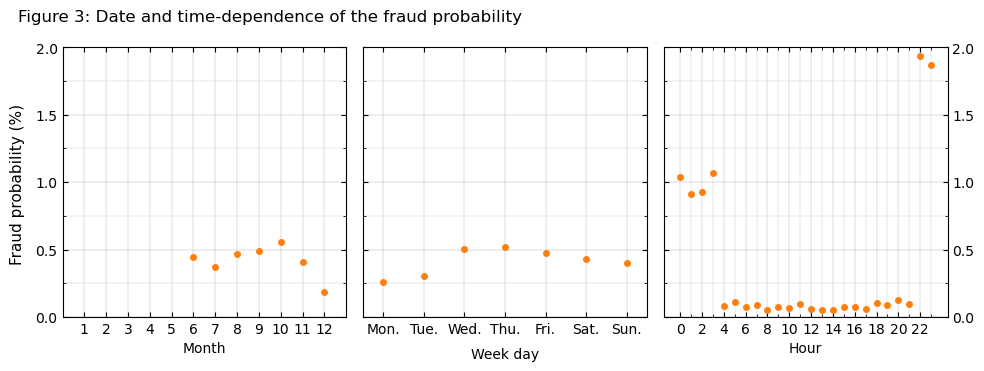

In [22]:
fig3, axs3 = plt.subplots(
    nrows=1, ncols=3, figsize=(10, 3.8), dpi=100, sharey=True,
    gridspec_kw={'left': 0.065, 'right': 0.95, 'top': 0.87, 'bottom': 0.16,
                 'wspace': 0.06})
fig3.suptitle("Figure 3: Date and time-dependence of the fraud probability",
              x=0.02, y=0.97, ha='left')

axs3[0].errorbar(months, 100*month_fprob, yerr=100*month_fprob_err,
                 color='tab:orange', linestyle='', marker='o', markersize=4)
axs3[0].tick_params(which='both', direction='in', top=True, right=True)
axs3[0].set_xlim(0, 13)
axs3[0].set_xticks(np.arange(1, 13))
axs3[0].set_xlabel('Month')
axs3[0].set_ylim(0, 2.)
axs3[0].set_yticks(np.linspace(0, 2, 5))
axs3[0].set_yticks(np.linspace(0.25, 1.75, 4), minor=True)
axs3[0].grid(visible=True, linewidth=0.3)
axs3[0].grid(visible=True, which='minor', linewidth=0.2)


axs3[1].errorbar(weekdays, 100*day_fprob, yerr=100*day_fprob_err,
                 color='tab:orange', linestyle='', marker='o', markersize=4)
axs3[1].tick_params(which='both', direction='in', top=True, right=True)
axs3[1].set_xlim(-0.5, 6.5)
axs3[1].set_xticks(np.arange(7),
                   ['Mon.', 'Tue.', 'Wed.', 'Thu.', 'Fri.', 'Sat.', 'Sun.'])
axs3[1].set_xlabel('Week day', labelpad=8)
axs3[1].grid(visible=True, linewidth=0.3)
axs3[1].grid(visible=True, which='minor', linewidth=0.2)


axs3[2].errorbar(hours, 100*hour_fprob, yerr=100*hour_fprob_err,
                 color='tab:orange', linestyle='', marker='o', markersize=4)
axs3[2].tick_params(which='both', direction='in', top=True,
                    right=True, labelright=True)
axs3[2].set_xlim(-1.5, 24.5)
axs3[2].set_xticks(np.arange(0, 24, 2))
axs3[2].set_xticks(np.arange(1, 24, 2), minor=True)
axs3[2].set_xlabel('Hour')
axs3[2].grid(visible=True, linewidth=0.3)
axs3[2].grid(visible=True, which='minor', linewidth=0.2)


fig3.text(0.02, 0.51, 'Fraud probability (%)', rotation=90, fontsize=11,
          ha='center', va='center')


plt.show()

Figure 3 shows the fraud probability as a function of the month (left panel), the week day (middle panel), and the day hour (right panel).
- Our data extends over a 6-month period, from june to december. Fraud occurrences are not very dependent on the month, except maybe a lower risk in december.
- Fraud occurences are also weakly dependent on the week day, except maybe a lower risk on mondays and tuesdays.
- There is however, a very strong dependence of fraud on the time of the transaction. Actually, frauds are much more frequents when transactions occur between 22:00 and 4:00. This dependence is stepped-like dependence is highly non-linear. It would be better capured by models such as decision trees.

### Combined effect of transaction amount and transaction time

We conclude with the study of the combined effect of the 2 most influencial factors determined previously: the transaction amount and the transaction time.

In [23]:
## Transaction amounts and 1D histogram bins
amount = df['amt'].to_numpy()
amt_bins = np.linspace(0, 1800, 91)

## Day time observations and 1D histogram bins
day_time = df['day_time'].to_numpy()
time_bins = np.linspace(0, 86400, 49)

## distrib
yx = np.meshgrid(time_bins, amt_bins, indexing='ij')
time_amt_hist = np.histogram2d(day_time, amount, bins=[time_bins, amt_bins])[0]

## fraud probability
is_fraud = df['is_fraud'].to_numpy()
amt_j = np.digitize(amount, amt_bins) - 1
time_i = np.digitize(day_time, time_bins) - 1
fraud_prob = np.zeros((len(time_bins)-1, len(amt_bins)-1))
for i in range(len(time_bins)-1):
    idx_i = (time_i == i)
    for j in range(len(amt_bins)-1):
        fraud_prob[i, j] = np.mean(is_fraud[(amt_j == j) * idx_i])

c:\Users\netes\anaconda3\envs\main\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\netes\anaconda3\envs\main\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


C:\Users\netes\AppData\Local\Temp\ipykernel_19600\1633602256.py:10: RuntimeWarning: divide by zero encountered in log
  heatmap = axs4[0].pcolormesh(*yx, np.log(time_amt_hist),


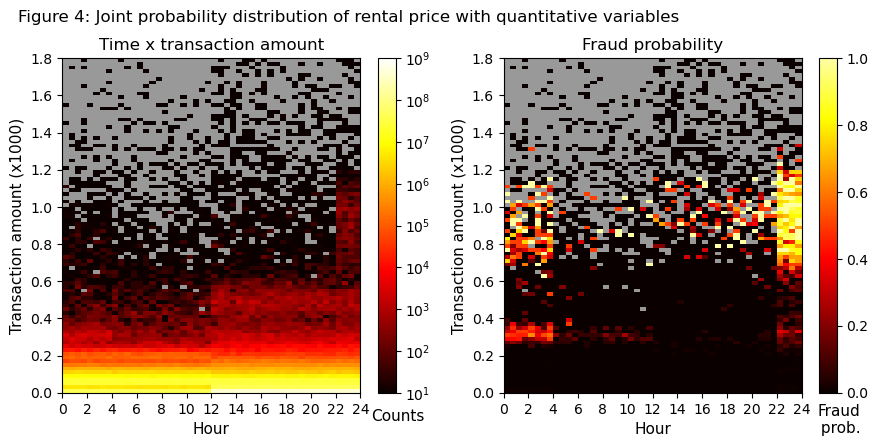

In [24]:
fig4, axs4 = plt.subplots(
    nrows=1, ncols=2, figsize=(8.8, 4.4), dpi=100, sharex=True,
    gridspec_kw={'left': 0.07, 'right': 0.91, 'top': 0.87, 'bottom': 0.11,
                 'wspace': 0.48})
fig4.suptitle("Figure 4: Joint probability distribution of rental price with quantitative variables",
              x=0.02, ha='left')

cmap4_0 = plt.get_cmap('hot').copy()
cmap4_0.set_extremes(bad='0.6', under=(0.0416, 0.0, 0.0, 1.0), over='0.6')
heatmap = axs4[0].pcolormesh(*yx, np.log(time_amt_hist),
                             cmap=cmap4_0, vmin=1, vmax=9)

axs4[0].set_xlim(0, np.max(time_bins))
axs4[0].set_xticks(np.linspace(0, 86400, 13), np.arange(0, 25, 2))
axs4[0].set_xlabel('Hour', fontsize=11)
axs4[0].set_ylim(0, np.max(amt_bins))
axs4[0].set_yticks(np.arange(0, 1900, 200),
                   [f'{x:.1f}' for x in np.linspace(0, 1.8, 10)])
axs4[0].set_ylabel('Transaction amount (x1000)', fontsize=11)
axs4[0].set_title('Time x transaction amount')

cax4_0 = fig4.add_axes((axs4[0]._position.get_points()[1, 0]+0.02,
                        axs4[0]._position.y0,
                        0.02,
                        axs4[0]._position.height))
fig4.colorbar(heatmap, cax=cax4_0, orientation="vertical", ticklocation="right")
cax4_0.set_yticks(np.linspace(1, 9, 9),
                  [rf'$10^{x}$' for x in np.arange(1, 10)])
cax4_0.text(1.1, -0.07, 'Counts', fontsize=11, ha='center', va='center',
            transform=cax4_0.transAxes)


cmap4_1 = plt.get_cmap('hot').copy()
cmap4_1.set_extremes(bad='0.6', under='0.7', over='0.5')
heatmap = axs4[1].pcolormesh(*yx, fraud_prob,
                             cmap=cmap4_1, vmin=0, vmax=1.1)
axs4[1].set_xlim(0, 86400)
axs4[1].set_xticks(np.linspace(0, 86400, 13), np.arange(0, 25, 2))
axs4[1].set_xlabel('Hour', fontsize=11)
axs4[1].set_yticks(np.arange(0, 1900, 200),
                   [f'{x:.1f}' for x in np.linspace(0, 1.8, 10)])
axs4[1].set_ylabel('Transaction amount (x1000)', fontsize=11)

cax4_1 = fig4.add_axes((axs4[1]._position.get_points()[1, 0]+0.02,
                        axs4[1]._position.y0,
                        0.02,
                        axs4[1]._position.height))
fig4.colorbar(heatmap, cax=cax4_1, orientation="vertical", ticklocation="right")
cax4_1.set_ylim(0, 1)
cax4_1.set_yticks(np.linspace(0, 1, 6))
cax4_1.text(1.1, -0.12, 'Fraud\n prob.', fontsize=11, ha='center',
            transform=cax4_1.transAxes)

axs4[1].set_title('Fraud probability')

plt.show()

Figure 4 presents the joint distribution of the transaction time and transaction amount (left panel), along with the fraud probability at the corresponding bins (right panel).

For the joint distribution, the counts in each bin are represented on a log scale to make the visualization clear despite the many orders of magintude difference between values. We again recover the fact that most transactions have low amount. However, we note a step-like dependence of the transaction amount on the time. High transaction amounts are lmore frequent in the afternoon, and even more so between 22:00 and 0:00. There is also a noticeable increase of high amounts between 0:00 and 4:00. When looking at the corresponding fraud probability, it appears clearly that these high transaction amount events are actually related to fraud attempts. 

## <a id="preproc_utils"></a> Data preprocessing and utilities

Before moving on to model construction and training, we first introduce here some utilities related to model evaluation. We also setup here the common parts of the training pipelines.


### Model evaluation utilities

We evaluate our classification models using metrics which are robust to the very high imbalance of fraud event occurences. These are derived from the confusion matrix:
- The precision
- The recall
- The F1 score

In [25]:
def eval_metrics(y_true: np.ndarray,
                 y_pred: np.ndarray,
                 print_cm: bool = False,
                 print_f1: bool = False)-> None:
    """
    Helper function that evaluates and return the relevant evaluation metrics:
        confusion matrix, precision, recall, F1-score
    """
    cm = confusion_matrix(y_true, y_pred)
    
    t = np.sum(cm, axis=1)[1]
    recall = (cm[1, 1] / t) if t != 0 else 1.
    t = np.sum(cm, axis=0)[1]
    prec = (cm[1, 1] / t) if t != 0 else 1.
    f1 = 2*prec*recall/(prec+recall)
    
    if print_cm:
        print("Confusion matrix\n", cm / np.sum(cm))
    if print_f1:
        print(f'Precision: {prec:.8}; recall: {recall:.8}')
        print(f'F1-score: {2*prec*recall/(prec+recall):.8}')
    
    return cm, prec, recall, f1

In [26]:
## Dataframe to hold the results
metric_names = ['precision', 'recall', 'F1-score']
index = pd.MultiIndex.from_product(
    [('Logistic regression', 'Random forest', 'hist gradient boosting'),
     ('train', 'test')],
    names=['model', 'eval. set'])
evaluation_df = pd.DataFrame(
    np.full((6, 3), np.nan), index=index, columns=metric_names)

### Data preprocessing

There is no need for data imputation nor outliers removal with this dataset. However, we will use models that require different feature preprocessing pipelines. For instance, trees do not require quantitative variable scaling nor one-hot encoding of categorical features. We setup the corresponding pipelines here.

In [27]:
## data preparation
y = df['is_fraud']
X = df.drop(['is_fraud', 'merchant_id', 'customer_id'], axis=1)

## train-test split
X_tr, X_test, y_tr, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1234)

In [28]:
## Column preprocessing for continuous function models (eg logistic regression)
func_cat_vars = ['month', 'weekday', 'category']
func_bool_vars = ['cust_fraudster', 'merch_fraud_victim']
func_quant_vars = ['amt', 'cos_day_time', 'sin_day_time']

func_col_preproc = ColumnTransformer(
    [('cat_ohe',
      OneHotEncoder(drop=None, handle_unknown='infrequent_if_exist', min_frequency=0.005),
      func_cat_vars),
     ('bool_id', FunctionTransformer(feature_names_out='one-to-one'), func_bool_vars),
     ('quant_scaler', StandardScaler(), func_quant_vars)]
)

In [29]:
## Column preprocessing for decision tree-derived models
tree_cat_vars = ['month', 'weekday', 'category']
tree_bool_vars = ['cust_fraudster', 'merch_fraud_victim']
tree_quant_vars = ['amt', 'day_time']

tree_col_preproc = ColumnTransformer(
    [('cat_oe', OrdinalEncoder(), tree_cat_vars),
     ('id_', FunctionTransformer(None, feature_names_out='one-to-one'),
      tree_bool_vars + tree_quant_vars)]
)

## <a id="logreg"></a> Logistic regression

We first begin by training a baseline logistic regression model.


### Regularization parameter optimization

The `LogisticRegression` classifier provided by `scikit-learn` has a regularization parameter `C` that must be set. We select the appropriate value with a grid search with cross-validation.

In [30]:
## Grid search of the regularization parameter with cross validation
scoring = ('precision',  'recall', 'f1')
Cs = np.logspace(-3, 4, 13)
base_lr = LogisticRegression(penalty='l2')
lr_clf = Pipeline(
    [('column_preprocessing', func_col_preproc),
     ('classifier', GridSearchCV(base_lr, param_grid={'C': Cs},
                                 scoring=scoring, n_jobs=4,
                                 refit=False, cv=5))]
)
lr_clf.fit(X_tr, y_tr)

Pipeline(steps=[('column_preprocessing',
                 ColumnTransformer(transformers=[('cat_ohe',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=0.005),
                                                  ['month', 'weekday',
                                                   'category']),
                                                 ('bool_id',
                                                  FunctionTransformer(feature_names_out='one-to-one'),
                                                  ['cust_fraudster',
                                                   'merch_fraud_victim']),
                                                 ('quant_scaler',
                                                  StandardScaler(),
                                                  ['amt', 'cos_day_time',
                                                   'sin...])])),
                ('classifier',
                 GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=4,
                              param_grid={'C': array([1.00000000e-03, 3.83118685e-03, 1.46779927e-02, 5.62341325e-02,
       2.15443469e-01, 8.25404185e-01, 3.16227766e+00, 1.21152766e+01,
       4.64158883e+01, 1.77827941e+02, 6.81292069e+02, 2.61015722e+03,
       1.00000000e+04])},
                              refit=False,
                              scoring=('precision', 'recall', 'f1')))])

In [31]:
## Extract the relevant metrics
cv_res = lr_clf['classifier'].cv_results_
prec = cv_res['mean_test_precision']
std_prec = cv_res['std_test_precision']
recall = cv_res['mean_test_recall']
std_recall = cv_res['std_test_recall']
f1 = cv_res['mean_test_f1']
std_f1 = cv_res['std_test_f1']

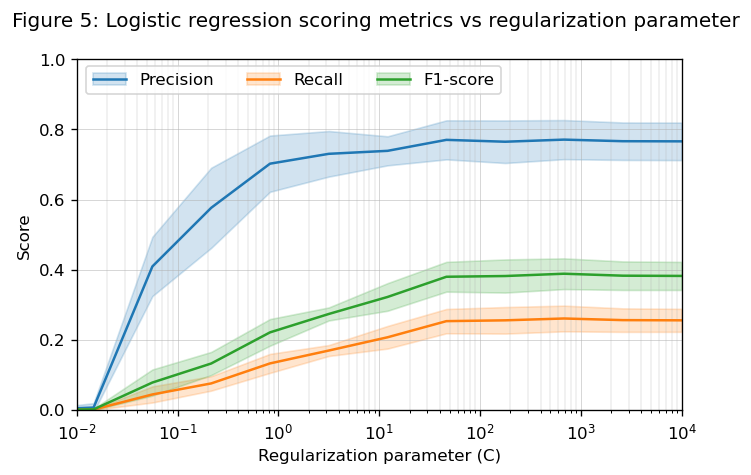

In [32]:
fig5, ax5 = plt.subplots(
    nrows=1, ncols=1, sharex=True, sharey=False, figsize=(6, 4), dpi=120,
    gridspec_kw={'left': 0.11, 'right': 0.95, 'top': 0.88, 'bottom': 0.15, 'wspace': 0.22})
fig5.suptitle("Figure 5: Logistic regression scoring metrics vs regularization parameter",
              x=0.02, ha='left')

l_prec, = ax5.plot(Cs, prec, color='C0', label='Precision')
fill_prec = ax5.fill_between(Cs, prec-std_prec, prec+std_prec,
                             color='C0', alpha=0.2)
l_rec, = ax5.plot(Cs, recall, color='C1', label='Recall')
fill_rec = ax5.fill_between(Cs, recall-std_recall, recall+std_recall,
                            color='C1', alpha=0.2)
l_f1, = ax5.plot(Cs, f1, color='C2', label='F1-score')
fill_f1 = ax5.fill_between(Cs, f1-std_f1, f1+std_f1,
                           color='C2', alpha=0.2)

ax5.set_xscale('log')
ax5.set_xlim(1e-2, 1e4)
ax5.set_xticks(np.logspace(-2, 4, 7))
ax5.set_xticks(
    np.concatenate([np.linspace(10**i, 10**(i+1), 10) for i in range(-2, 4)]),
    minor=True)
ax5.set_xlabel('Regularization parameter (C)')
ax5.set_ylim(0, 1)
ax5.set_ylabel('Score')
ax5.grid(visible=True, linewidth=0.3)
ax5.grid(visible=True, which='minor', linewidth=0.2)

ax5.legend(handles=[(l_prec, fill_prec), (l_rec, fill_rec), (l_f1, fill_f1)],
           labels=['Precision', 'Recall', 'F1-score'],
           loc=(0.015, 0.9), ncols=3)


plt.show()

Figure 5 presents the evolution of the selected metrics, precision, recall and F1-score, with varying regularization parameter `C`. The light-colored band around the main curve represent the standard deviation across cross-validation samples. The performance of the model increases with `C` (which corresponds to a decrease in the regularization strength). This performance increase reaches a plateau at a F1-score of about 0.4 for $C \geq 100$.

### Model training and evaluation

According to the previous results, we retain a value $C = 1000$ for our L2-regularized logistic regression, a very weak regularization.

In [33]:
## Complete pipeline
lr_model = Pipeline([('column_preprocessing', func_col_preproc),
                     ('classifier', LogisticRegression(C=1e3))])

## train
t0 = time.time()
lr_model.fit(X_tr, y_tr)
t1 = time.time()
print(f'Logistic regression training in {t1-t0:.2f} s')

Logistic regression training in 1.16 s


In [34]:
## evaluate of train set
y_pred_tr = lr_model.predict(X_tr)
_, prec, recall, f1 = eval_metrics(y_tr, y_pred_tr)
evaluation_df.iloc[0] = prec, recall, f1

## evaluate on test set
y_pred_test = lr_model.predict(X_test)
_, prec, recall, f1 = eval_metrics(y_test, y_pred_test)
evaluation_df.iloc[1] = prec, recall, f1

In [35]:
evaluation_df

precision    recall  F1-score
model                  eval. set                               
Logistic regression    train       0.767213  0.272727  0.402408
                       test        0.789116  0.270396  0.402778
Random forest          train            NaN       NaN       NaN
                       test             NaN       NaN       NaN
hist gradient boosting train            NaN       NaN       NaN
                       test             NaN       NaN       NaN

The model does not overfit. However, with a F1-score of only 0.40, it has poor performance. This is due to a low recall, the model has a high false negatives rate.

## <a id="random_forest"></a> Random forest

As a second model, we train a random forest classifier. This model is expected to perform much better than the previous logistic regression due to its ability to capture the non-linear relationship between time/transaction amount and the fraud risk. For this reason, we need not include the derived features `cos_day_time` and `cos_day_time` in the model.


### Parameters optimization

There is a strong risk of overfitting for tree-based models if allowed to grow too deep (in addition to the excessive training times). We thus first select the random forest `max_depth` parameter by cross validation.

In [36]:
## Grid search of the max tree depth parameter with cross validation
scoring = ('precision',  'recall', 'f1')
max_depths = np.arange(3, 19, 1)
base_rfc = RandomForestClassifier(n_estimators=200,
                                  criterion='gini',
                                  bootstrap=True,
                                  random_state=1234)
rf_clf = Pipeline(
    [('column_preprocessing', tree_col_preproc),
     ('classifier', GridSearchCV(base_rfc, param_grid={'max_depth': max_depths},
                                 scoring=scoring, n_jobs=4, refit=False, cv=5))]
)
rf_clf.fit(X_tr, y_tr)

Pipeline(steps=[('column_preprocessing',
                 ColumnTransformer(transformers=[('cat_oe', OrdinalEncoder(),
                                                  ['month', 'weekday',
                                                   'category']),
                                                 ('id_',
                                                  FunctionTransformer(feature_names_out='one-to-one'),
                                                  ['cust_fraudster',
                                                   'merch_fraud_victim', 'amt',
                                                   'day_time'])])),
                ('classifier',
                 GridSearchCV(cv=5,
                              estimator=RandomForestClassifier(n_estimators=200,
                                                               random_state=1234),
                              n_jobs=4,
                              param_grid={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18])},
                              refit=False,
                              scoring=('precision', 'recall', 'f1')))])

In [37]:
## Extract the relevant metrics
cv_res = rf_clf['classifier'].cv_results_
prec = cv_res['mean_test_precision']
std_prec = cv_res['std_test_precision']
recall = cv_res['mean_test_recall']
std_recall = cv_res['std_test_recall']
f1 = cv_res['mean_test_f1']
std_f1 = cv_res['std_test_f1']

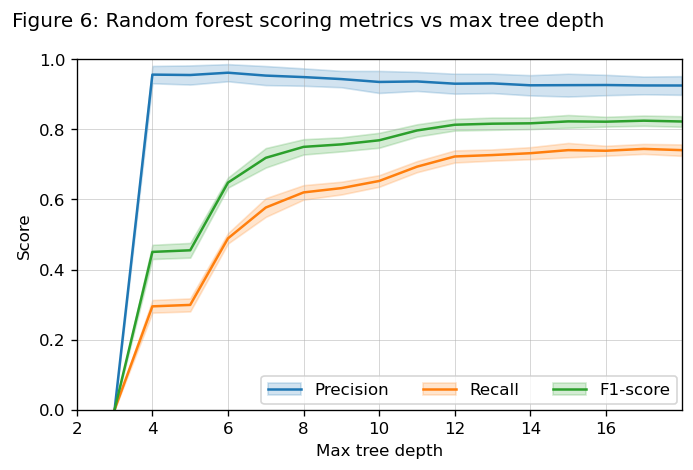

In [38]:
fig6, ax6 = plt.subplots(
    nrows=1, ncols=1, sharex=True, sharey=False, figsize=(6, 4), dpi=120,
    gridspec_kw={'left': 0.11, 'right': 0.95, 'top': 0.88, 'bottom': 0.15, 'wspace': 0.22})
fig6.suptitle("Figure 6: Random forest scoring metrics vs max tree depth",
              x=0.02, ha='left')

l_prec, = ax6.plot(max_depths, prec, color='C0', label='Precision')
fill_prec = ax6.fill_between(max_depths, prec-std_prec, prec+std_prec,
                             color='C0', alpha=0.2)
l_rec, = ax6.plot(max_depths, recall, color='C1', label='Recall')
fill_rec = ax6.fill_between(max_depths, recall-std_recall, recall+std_recall,
                            color='C1', alpha=0.2)
l_f1, = ax6.plot(max_depths, f1, color='C2', label='F1-score')
fill_f1 = ax6.fill_between(max_depths, f1-std_f1, f1+std_f1,
                           color='C2', alpha=0.2)

ax6.set_xlim(2, max(max_depths))
ax6.set_xticks(np.arange(2, 18, 2))
ax6.set_xlabel('Max tree depth')
ax6.set_ylim(0, 1)
ax6.set_ylabel('Score')
ax6.grid(visible=True, linewidth=0.3)
ax6.grid(visible=True, which='minor', linewidth=0.2)
ax6.legend(handles=[(l_prec, fill_prec), (l_rec, fill_rec), (l_f1, fill_f1)],
           labels=['Precision', 'Recall', 'F1-score'],
           loc=(0.305, 0.015), ncols=3)


plt.show()

The performance of the model increases with the max tree depth to reach a plateau at `max_depth = 14`, and a corresponding F1-score slightly above 0.8.

### Model training and evaluation

We select `max_depth = 14` to train the random forest model.

In [39]:
## Complete pipeline
rf_model = Pipeline(
    [('column_preprocessing', tree_col_preproc),
     ('classifier', RandomForestClassifier(n_estimators=200,
                                           criterion='gini',
                                           max_depth=14,
                                           bootstrap=True,
                                           n_jobs=4,
                                           random_state=1234))]
)

## train
t0 = time.time()
rf_model.fit(X_tr, y_tr)
t1 = time.time()
print(f'Random forest model training in {t1-t0:.2f} s')

Random forest model training in 14.72 s


In [40]:
## evaluate of train set
y_pred_tr = rf_model.predict(X_tr)
_, prec, recall, f1 = eval_metrics(y_tr, y_pred_tr)
evaluation_df.iloc[2] = prec, recall, f1

## evaluate on test set
y_pred_test = rf_model.predict(X_test)
_, prec, recall, f1 = eval_metrics(y_test, y_pred_test)
evaluation_df.iloc[3] = prec, recall, f1

In [41]:
evaluation_df

precision    recall  F1-score
model                  eval. set                               
Logistic regression    train       0.767213  0.272727  0.402408
                       test        0.789116  0.270396  0.402778
Random forest          train       0.993084  0.836830  0.908286
                       test        0.937500  0.734266  0.823529
hist gradient boosting train            NaN       NaN       NaN
                       test             NaN       NaN       NaN

The random forest model shows good performance, with a F1-score of 0.82 on the test set. Similarly to the logistic regression, there is an asymmetry between precision and recall, the later being significantly lower as a consequence of the strong imbalance between fraud and non-fraud events. However, the random forest model clearly overfits the data, with scores 0.07 - 0.1 higher on the training data than on the test data.

## <a id="hist_gradient_boosting"></a> Histogram-based Gradient Boosting model

We complete our models catalogue by training an histogram-based gradient boosting classifier. Due to data binning, the convergence is much faster than plain gradient boosting. However, this comes at the price of a possible lower performance than its counterpart.


### Parameters optimization

The `HistGradientBoostingClassifier` implementation of `scikit-learn` proposes to add L2 regularization to limit overfitting. We select this parameter by cross validation.

In [42]:
## Grid search of the L2 regularization parameter with cross validation
scoring = ('precision',  'recall', 'f1')
l2_reg_vals = np.logspace(-3, 3, 19)
base_hgb = HistGradientBoostingClassifier(categorical_features=np.arange(5),
                                          random_state=1234)
hgb_clf = Pipeline(
    [('column_preprocessing', tree_col_preproc),
     ('classifier',
      GridSearchCV(base_hgb,
                   param_grid={'l2_regularization': l2_reg_vals},
                   scoring=scoring, n_jobs=4, refit=False, cv=5))]
)
hgb_clf.fit(X_tr, y_tr)

Pipeline(steps=[('column_preprocessing',
                 ColumnTransformer(transformers=[('cat_oe', OrdinalEncoder(),
                                                  ['month', 'weekday',
                                                   'category']),
                                                 ('id_',
                                                  FunctionTransformer(feature_names_out='one-to-one'),
                                                  ['cust_fraudster',
                                                   'merch_fraud_victim', 'amt',
                                                   'day_time'])])),
                ('classifier',
                 GridSearchCV(cv=5,
                              estimator=HistGradientBoostingClassifier(categorical_features=array...
                              param_grid={'l2_regularization': array([1.00000000e-03, 2.15443469e-03, 4.64158883e-03, 1.00000000e-02,
       2.15443469e-02, 4.64158883e-02, 1.00000000e-01, 2.15443469e-01,
       4.64158883e-01, 1.00000000e+00, 2.15443469e+00, 4.64158883e+00,
       1.00000000e+01, 2.15443469e+01, 4.64158883e+01, 1.00000000e+02,
       2.15443469e+02, 4.64158883e+02, 1.00000000e+03])},
                              refit=False,
                              scoring=('precision', 'recall', 'f1')))])

In [43]:
## Extract the relevant metrics
cv_res = hgb_clf['classifier'].cv_results_
prec = cv_res['mean_test_precision']
std_prec = cv_res['std_test_precision']
recall = cv_res['mean_test_recall']
std_recall = cv_res['std_test_recall']
f1 = cv_res['mean_test_f1']
std_f1 = cv_res['std_test_f1']

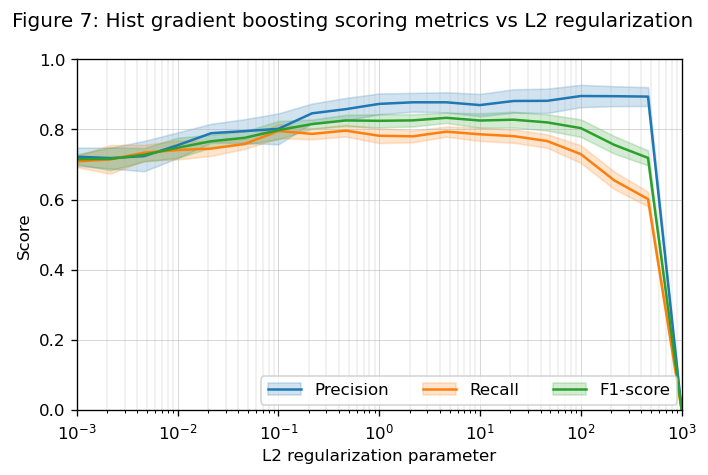

In [44]:
fig7, ax7 = plt.subplots(
    nrows=1, ncols=1, sharex=True, sharey=False, figsize=(6, 4), dpi=120,
    gridspec_kw={'left': 0.11, 'right': 0.95, 'top': 0.88, 'bottom': 0.15, 'wspace': 0.22})
fig7.suptitle("Figure 7: Hist gradient boosting scoring metrics vs L2 regularization",
              x=0.02, ha='left')


l_prec, = ax7.plot(l2_reg_vals, prec, color='C0', label='Precision')
fill_prec = ax7.fill_between(l2_reg_vals, prec-std_prec, prec+std_prec,
                             color='C0', alpha=0.2)
l_rec, = ax7.plot(l2_reg_vals, recall, color='C1', label='Recall')
fill_rec = ax7.fill_between(l2_reg_vals, recall-std_recall, recall+std_recall,
                            color='C1', alpha=0.2)
l_f1, = ax7.plot(l2_reg_vals, f1, color='C2', label='F1-score')
fill_f1 = ax7.fill_between(l2_reg_vals, f1-std_f1, f1+std_f1,
                           color='C2', alpha=0.2)
ax7.set_xscale('log')
ax7.set_xlim(1e-3, 1e3)
ax7.set_xlabel('L2 regularization parameter')
ax7.set_ylim(0, 1)
ax7.set_ylabel('Score')
ax7.grid(visible=True, linewidth=0.3)
ax7.grid(visible=True, which='minor', linewidth=0.2)
ax7.legend(handles=[(l_prec, fill_prec), (l_rec, fill_rec), (l_f1, fill_f1)],
           labels=['Precision', 'Recall', 'F1-score'],
           loc=(0.305, 0.015), ncols=3)


plt.show()

Figure 7 presents the scoring metrics as a function of the L2 regularization parameter, with the light bands representing the standard deviation across the cross-validation samples. The model actually benefits from some amount of L2 regularization (contrary for instance to the logistic regression). The model performance increases with the regularization parameter up to a plateau between 0.2 and 30 for the regularization parameter, after which the performance quickly drops to zero. The F1-score on the plateau is slightly above 0.8.

### Model training and evaluation

According to the previous results, we select a value `l2_regularization = 3` for our final histogram-based gradient boosting model.

In [45]:
## Complete pipeline
hgb_model = Pipeline(
    [('column_preprocessing', tree_col_preproc),
     ('regressor', HistGradientBoostingClassifier(l2_regularization=3,
                                                  categorical_features=np.arange(5),
                                                  random_state=1234))]
)

## train
t0 = time.time()
hgb_model.fit(X_tr, y_tr)
t1 = time.time()
print(f'Hist gradient boosting model training in {t1-t0:.2f} s')

Hist gradient boosting model training in 2.16 s


In [46]:
## evaluate of train set
y_pred_tr = hgb_model.predict(X_tr)
_, prec, recall, f1 = eval_metrics(y_tr, y_pred_tr)
evaluation_df.iloc[4] = prec, recall, f1

## evaluate on test set
y_pred_test = hgb_model.predict(X_test)
_, prec, recall, f1 = eval_metrics(y_test, y_pred_test)
evaluation_df.iloc[5] = prec, recall, f1

In [47]:
evaluation_df

precision    recall  F1-score
model                  eval. set                               
Logistic regression    train       0.767213  0.272727  0.402408
                       test        0.789116  0.270396  0.402778
Random forest          train       0.993084  0.836830  0.908286
                       test        0.937500  0.734266  0.823529
hist gradient boosting train       0.916510  0.850816  0.882442
                       test        0.873656  0.757576  0.811486

With a test set F1-score of 0.81, this last model exhibits similar performance as the random forest. However, contrary to the latter, overfitting is less pronounced, with lower score differences between train and test sets, in the range 0.04 - 0.07. The imbalance between precision and recall is also lower than that of the random forest.